In [166]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import random
from itertools import chain

from ipynb.fs.full.GenerateData import generatedata

In [152]:
data = pd.read_csv('data/people.csv')

In [153]:
data.columns

Index(['index', 'id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age',
       'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date', 'decile_score', 'score_text', 'violent_recid',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_days_from_compas', 'c_arrest_date',
       'c_offense_date', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'num_r_cases', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc'],
      dtype='object')

In [154]:
##################### WARNING!!
# remove records with decile_score = -1
# not sure yet what that is, but for now we're going to clean that data out
data = data[data.decile_score > 0]

In [155]:
##################### WARNING!!!
# need to create a target variable for whether defendant was remanded or released on bail.
# hopefully we will have this data in the future; for now, artificially create this data:
# for participants where compas decile_score > 6: remand; if decile_score < 3: release; else, randomly select remand or release

deciles = data['decile_score']
release = []

for x in deciles:
    if deciles[x] > 6:
        release.append(random.choices([0,1],weights=[90,10]))
    elif deciles[x] < 4:
        release.append(random.choices([0,1],weights=[10,90]))
    else:
        release.append(random.choices([0,1],weights=[50,50]))
        
# re-insert into data frame
data['release'] = list(chain.from_iterable(release))

In [156]:
data[['decile_score','release']].head()

,decile_score,release
0,1,0
1,5,0
2,3,1
3,4,0
4,8,1


In [157]:
# check how many released/remanded
data.release.value_counts()

1    6872
0    4870
Name: release, dtype: int64

In [158]:
# check how many released/remanded by decile_score
pd.crosstab(data.decile_score, data.release)

release,0,1
decile_score,,
1,1288,1289
2,156,1416
3,635,624
4,1078,121
5,99,935
6,104,889
7,469,431
8,400,396
9,76,726


In [159]:
# select out relevant data
# for now, we're only going off of the risk assessment score
data = data[['release','decile_score']]

y actual : 
1    1728
0    1208
Name: release, dtype: int64

y predicted : 
1    2936
dtype: int64

Accuracy Score : 0.5885558583106267

Precision Score : 0.5885558583106267

Recall Score : 1.0

F1 Score : 0.7409948542024014

Confusion Matrix : 
[[   0 1208]
 [   0 1728]]

Confusion matrix, without normalization
[[   0 1208]
 [   0 1728]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


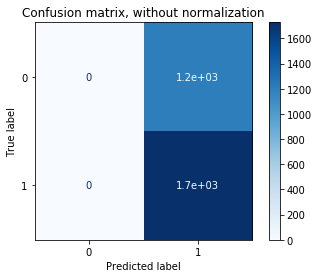

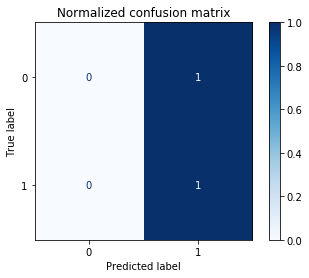

In [160]:
# Start with a really basic baseline model
# Going to use dummy classifier - this will only predict the majority case (i.e. release)

# train / test
X = data.drop(['release'],axis=1)
y = data['release']
class_names = data.release.unique()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

classify = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred = classify.predict(X_test)

#Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))
print()

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))
print()

# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print()
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print()
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print()
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print()

#Dummy Classifier Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))
print()

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classify, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


Accuracy Score : 0.5885558583106267

Precision Score : 0.5885558583106267

Recall Score : 1.0

F1 Score : 0.7409948542024014

Confusion Matrix : 
[[   0 1208]
 [   0 1728]]
Confusion matrix, without normalization
[[   0 1208]
 [   0 1728]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


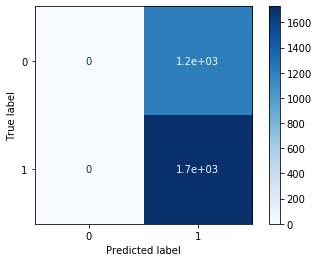

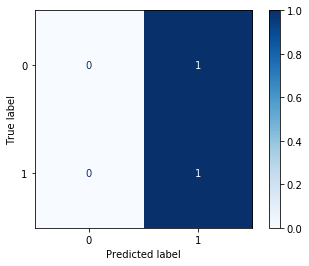

In [162]:
# next, we'll do a really simple logistic regression where the IV is simply the compas decile_score

logit_classify = LogisticRegression().fit(X_train,y_train)
logit_y_pred = logit_classify.predict(X_test)

# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(y_test,logit_y_pred)))
print()
print('Precision Score : ' + str(precision_score(y_test,logit_y_pred)))
print()
print('Recall Score : ' + str(recall_score(y_test,logit_y_pred)))
print()
print('F1 Score : ' + str(f1_score(y_test,logit_y_pred)))
print()

#Logistic Regression Classifier Confusion matrix & plot
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,logit_y_pred)))

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    logit_disp = plot_confusion_matrix(logit_classify, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(logit_disp.confusion_matrix)